In [ ]:
! pip install transformers
#importing the libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import transformers
from transformers import BertTokenizer,BertModel,AdamW,get_linear_schedule_with_warmup
import tqdm.auto as tqdm
import torch.nn.functional as F
from pylab import rcParams
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report,recall_score,precision_score,f1_score,roc_curve
from torch import nn,optim
from textwrap import wrap
from torch.utils.data import Dataset, DataLoader
from wordcloud import WordCloud
from textwrap import wrap

import matplotlib.pyplot as plt
from matplotlib import font_manager

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ['#FFD700', '#FFA500', '#FF6347', '#ADFF2F', '#20B2AA']
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 8, 4
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
import warnings
warnings.filterwarnings('ignore')
!wget https://www.easynepalityping.com/resource/font/bangla/06-nikosh-bangla-font.zip
!unzip 06-nikosh-bangla-font.zip

--2024-11-22 15:48:41--  https://www.easynepalityping.com/resource/font/bangla/06-nikosh-bangla-font.zip
Resolving www.easynepalityping.com (www.easynepalityping.com)... 172.67.165.83, 104.21.11.66, 2606:4700:3035::ac43:a553, ...
Connecting to www.easynepalityping.com (www.easynepalityping.com)|172.67.165.83|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 317905 (310K) [application/zip]
Saving to: ‘06-nikosh-bangla-font.zip’

06-nikosh-bangla-fo 100%[===================>] 310.45K  --.-KB/s    in 0.04s   

2024-11-22 15:48:41 (7.47 MB/s) - ‘06-nikosh-bangla-font.zip’ saved [317905/317905]

Archive:  06-nikosh-bangla-font.zip
  inflating: Nikosh.ttf              


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df=pd.read_csv("/content/drive/MyDrive/BanglaNewsHeadline_Classifications_with_BanglaBERT/BAN-ABSA.csv")
df.sample(10)

,post,aspect,polarity
6112,তবে সিরিয়ার সাধারন জনগনের দিকে তাকালে আমেরিকাক...,politics,positive
2484,না খুনি হাসিনাকে মানিনা,politics,negative
2508,আল্লাহ তায়ালা আপনাকে নেক হায়াত দান করুক,religion,positive
6260,আপনি বলার কে,other,negative
1188,নির্বাচনে এসে টাকা খরচা করার দরকার নাই।,politics,negative
6790,বাংলাদেশ এগিয়ে চলো সত্য ও ন্যায়ের পথে কিরে,other,positive
315,কিন্তু আপনার ভোটাররাও লজ্জিত,politics,negative
1568,ভারতের পাশে যখন বলছে হাসিনা আছে তখন আমি পুরো চ...,politics,negative
3087,তিনি কে জাতির উদ্দেশে ভাষন দেওয়ার??,politics,neutral
8885,নবম শ্রেণীতে থাকাবস্তায় ধর্ষকের খাতায় নাম লিখি...,other,negative


In [ ]:
#check the rows and columns number.
print(f"number of rows:--> {df.shape[0]} and number of columns:--> {df.shape[1]}")

number of rows:--> 9014 and number of columns:--> 3


In [ ]:
#check for missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9014 entries, 0 to 9013
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   post      9014 non-null   object
 1   aspect    9014 non-null   object
 2   polarity  9013 non-null   object
dtypes: object(3)
memory usage: 211.4+ KB


In [ ]:
#check for missing values
def checking_m(df):
    null_v = df.isnull().sum().sort_values(ascending=False)
    null_percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    null_v = pd.concat([null_v, null_percent], axis=1, keys=['Missing_Number', 'Missing_Percent'])
    return null_v

checking_m(df)

,Missing_Number,Missing_Percent
polarity,1,0.000111
post,0,0.000000
aspect,0,0.000000


In [ ]:
#check for missing values
def checking_m(df):
    null_v = df.isnull().sum().sort_values(ascending=False)
    null_percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    null_v = pd.concat([null_v, null_percent], axis=1, keys=['Missing_Number', 'Missing_Percent'])
    return null_v

checking_m(df)

,Missing_Number,Missing_Percent
polarity,1,0.000111
post,0,0.000000
aspect,0,0.000000


In [ ]:
df=df.dropna()

In [ ]:
#check for missing values
def checking_m(df):
    null_v = df.isnull().sum().sort_values(ascending=False)
    null_percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    null_v = pd.concat([null_v, null_percent], axis=1, keys=['Missing_Number', 'Missing_Percent'])
    return null_v

checking_m(df)

,Missing_Number,Missing_Percent
post,0,0.0
aspect,0,0.0
polarity,0,0.0


In [ ]:
#check for dublicated rows
print("Numbers of duplicated rows :",df.duplicated().sum())

Numbers of duplicated rows : 7


In [ ]:
#dropping the duplicated rows
df=df.drop_duplicates(keep="first")
print("After removing,now number of duplicated rows are:",df.duplicated().sum())

After removing,now number of duplicated rows are: 0


# **EDA and Preprocessing**

In [ ]:
df.aspect.value_counts()

,count
aspect,
other,3009
politics,2662
religion,1752
sports,1583


In [ ]:
df.polarity.value_counts()

,count
polarity,
negative,4721
positive,2616
neutral,1669


Text(0.5, 0, 'category')

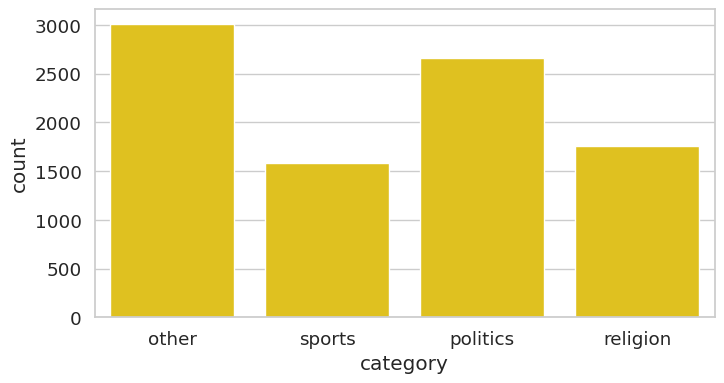

In [ ]:
#check for imblanced classes
sns.countplot(data=df,x="aspect")
plt.xlabel('category')

Text(0.5, 0, 'category')

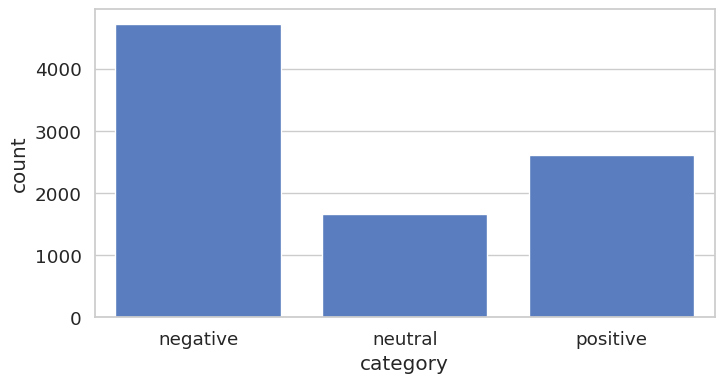

In [ ]:
#check for imblanced classes
#check for imblanced classes
sns.countplot(data=df,x="polarity",color="b")
plt.xlabel('category')

In [ ]:
#counting text length
df['count'] = df['post'].str.split().str.len()

# Remove the text with words less than 3
df= df.loc[df['count']>3]

In [ ]:
df.head()

,post,aspect,polarity,count
0,ছি. এর চেয়ে নিরখিষণ্ট আর কিছু হতে পারেনা।,other,negative,8
1,এটা ফুটবল ইতিহাসের দুভাগ্য,sports,negative,4
2,এই হল সংলাপের নমুনা ।,other,neutral,5
3,আমার পরিসংখ্যান অনুযায়ী বলা যাচ্ছে এটা ম্যাশের...,sports,neutral,11
4,"রুহুল আমিন হাওলাদার নিজের আসনে কয়ভোট পাবে, সে ...",politics,neutral,10


In [ ]:
df.shape

(7859, 4)

In [ ]:
df.aspect.value_counts()

,count
aspect,
other,2390
politics,2383
religion,1575
sports,1511


In [ ]:
import re
def replace_strings(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           u"\u00C0-\u017F"          #latin
                           u"\u2000-\u206F"          #generalPunctuations

                           "]+", flags=re.UNICODE)
    english_pattern=re.compile('[a-zA-Z0-9]+', flags=re.I)
    #latin_pattern=re.compile('[A-Za-z\u00C0-\u00D6\u00D8-\u00f6\u00f8-\u00ff\s]*',)

    text=emoji_pattern.sub(r'', text)
    text=english_pattern.sub(r'', text)

    return text

def remove_punctuations(my_str):
    # define punctuation
    punctuations = '''````£|¢|Ñ+-*/=EROero৳০১২৩৪৫৬৭৮৯012–34567•89।!()-[]{};:'"“\’,<>./?@#$%^&*_~‘—॥”‰🤣⚽️✌�￰৷￰'''

    no_punct = ""
    for char in my_str:
        if char not in punctuations:
            no_punct = no_punct + char

    # display the unpunctuated string
    return no_punct

def preprocessing(text):
    out=remove_punctuations(replace_strings(text))
    return out

In [ ]:
df['cleanText'] = df.post.apply(lambda x: preprocessing(str(x)))

In [ ]:
df.sample(10)

,post,aspect,polarity,count,cleanText
2634,আন্দোলন আন্দোলন বলে হোদাই সময় নষ্ট করতেছেন কেনো,other,negative,8,আন্দোলন আন্দোলন বলে হোদাই সময় নষ্ট করতেছেন কেনো
3893,ম্যাশ বসের জন্য রইলো শুভকামনা,sports,positive,5,ম্যাশ বসের জন্য রইলো শুভকামনা
5745,শুধু আপনি নাই বলে এই সিরিজের একটা খেলাও দেখবো না,sports,negative,10,শুধু আপনি নাই বলে এই সিরিজের একটা খেলাও দেখবো না
2425,আমার দেখা সেরা মুহূর্ত গেইল সিঙ্গেল নিয়ে ম্যাশ...,sports,neutral,10,আমার দেখা সেরা মুহূর্ত গেইল সিঙ্গেল নিয়ে ম্যাশ...
4651,"নবীজি পুরাই দুইমুখী,শুধু মজা দেয়",religion,negative,5,নবীজি পুরাই দুইমুখীশুধু মজা দেয়
2433,আল্লাহ আপনাকে হায়াত দান করুন আমিন,religion,positive,6,আল্লাহ আপনাকে হায়াত দান করুন আমিন
7599,এই মুহুত্তে নির্বাচন প্রধান ইস্যু না,politics,neutral,6,এই মুহুত্তে নির্বাচন প্রধান ইস্যু না
6304,উগান্ডার এক নেত্রি উনার ভেতরে ক্ষমতার লোভ নাই,politics,positive,8,উগান্ডার এক নেত্রি উনার ভেতরে ক্ষমতার লোভ নাই
7713,বদমাশটার উপর আল্লাহর গজব পড়বে।,other,negative,5,বদমাশটার উপর আল্লাহর গজব পড়বে
128,জাতিরপিতা শেখ মজিবরের দেশ গড়ার লক্ষে সর্ব দিক ...,politics,positive,14,জাতিরপিতা শেখ মজিবরের দেশ গড়ার লক্ষে সর্ব দিক ...


In [ ]:
data1 =pd.read_excel('/content/drive/MyDrive/BanglaNewsHeadline_Classifications_with_BanglaBERT/stopwords_bangla.xlsx')
stop = data1['words'].tolist()

In [ ]:
data1.head()


,Unnamed: 0,words
0,0,অই
1,1,অগত্যা
2,2,অত: পর
3,3,অতএব
4,4,অথচ


In [ ]:
display(data1)

,Unnamed: 0,words
0,0,অই
1,1,অগত্যা
2,2,অত: পর
3,3,অতএব
4,4,অথচ
...,...,...
727,727,হয়েই
728,728,হয়েছিল
729,729,হয়েছে
730,730,হয়েছেন


In [ ]:
df.aspect.value_counts()

,count
aspect,
other,2390
politics,2383
religion,1575
sports,1511


In [ ]:
df.polarity.value_counts()

,count
polarity,
negative,4142
positive,2214
neutral,1503


In [ ]:
def stopwordRemoval(text):
    x=str(text)
    l=x.split()

    stm=[elem for elem in l if elem not in stop]

    out=' '.join(stm)

    return str(out)

In [ ]:
df['cleanText'] = df.cleanText.apply(lambda x: stopwordRemoval(str(x)))

In [ ]:
#counting text length
df['counts'] = df['cleanText'].str.split().str.len()

# Remove the text with words less than 5
df= df.loc[df['counts']>3]

In [ ]:
df.head()

,post,aspect,polarity,count,cleanText,counts
3,আমার পরিসংখ্যান অনুযায়ী বলা যাচ্ছে এটা ম্যাশের...,sports,neutral,11,পরিসংখ্যান ম্যাশের হইতো এশিয়া কাপ,5
4,"রুহুল আমিন হাওলাদার নিজের আসনে কয়ভোট পাবে, সে ...",politics,neutral,10,রুহুল আমিন হাওলাদার আসনে কয়ভোট পাবে নিজেও জানেনা,8
6,হয়তো কিছুদিন পর মাঠে দেখা যাবে না কিন্তু আপনা...,sports,positive,13,কিছুদিন মাঠে না ভালোবাসা চিরকাল,5
7,"সংলাপ সফল হয়নি, আন্দোলন চলবে।",politics,negative,5,সংলাপ সফল আন্দোলন চলবে,4
9,"আল্লাহ সর্বজ্ঞ, সর্ববিষয়ে সম্যক জ্ঞাত।",religion,positive,5,আল্লাহ সর্বজ্ঞ সর্ববিষয়ে সম্যক জ্ঞাত,5


In [ ]:
df.aspect.value_counts()

,count
aspect,
politics,1922
other,1521
religion,1313
sports,1307


In [ ]:
#make sure to turn on internet on your kernel
#importing stemmer
!pip install bangla-stemmer
from bangla_stemmer.stemmer import stemmer
## stemmer function
def stem_text (x):
    stmr = stemmer.BanglaStemmer()
    words=x.split(' ')
    stm = stmr.stem(words)
    words=(' ').join(stm)
    return words

In [ ]:
df['cleanText']=df['cleanText'].apply(stem_text)

Streaming output truncated to the last 5000 lines.
applied fourth rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied first rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied first rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied first rules..
applied second rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied first rules..

In [ ]:
temp1 = df.groupby('aspect').count()['cleanText'].reset_index().sort_values(by='cleanText',ascending=False)
temp1.style.background_gradient(cmap='Purples')

,aspect,cleanText
1,politics,1922
0,other,1521
2,religion,1313
3,sports,1307


In [ ]:
temp2 = df.groupby('polarity').count()['cleanText'].reset_index().sort_values(by='cleanText',ascending=False)
temp2.style.background_gradient(cmap='Purples')

,polarity,cleanText
0,negative,3245
2,positive,1751
1,neutral,1067


In [ ]:
# Function for generating word clouds
def generate_wordcloud(data,title):
  data = [tuple(x) for x in data.values]
  wc = WordCloud(font_path="/content/drive/MyDrive/BanglaNewsHeadline_Classifications_with_BanglaBERT/Siyamrupali.ttf",width=1080, height=740, max_words=150,colormap="Dark2").generate_from_frequencies(dict(data))
  plt.figure(figsize=(10,8))
  plt.imshow(wc, interpolation='bilinear')
  plt.axis("off")
  plt.title('\n'.join(wrap("Word Cloud of "+title,60)),fontsize=13)
  plt.show()

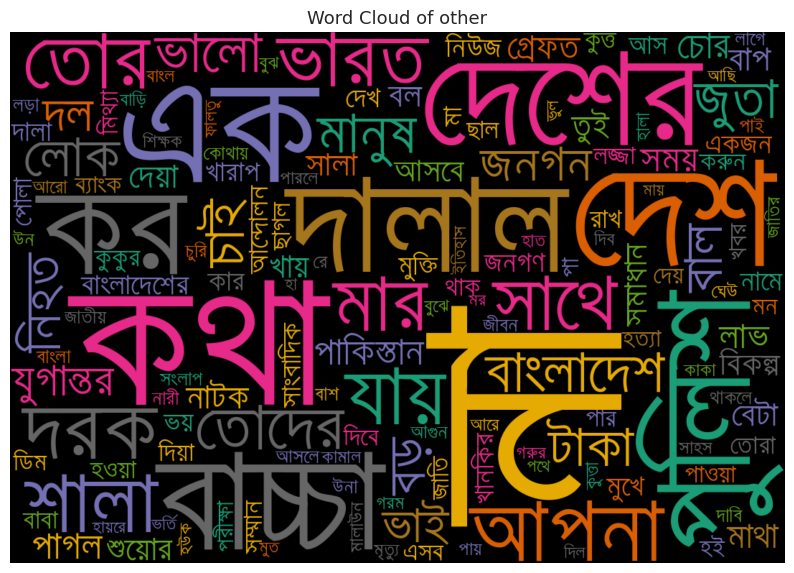

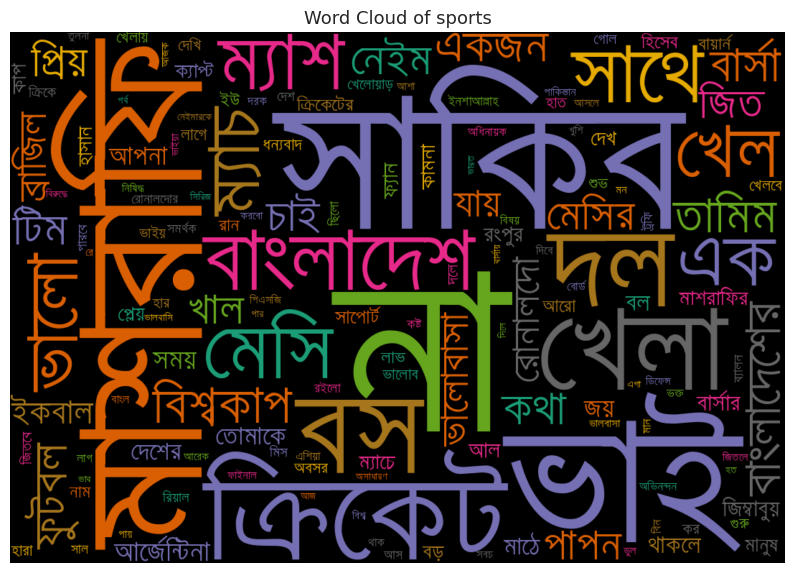

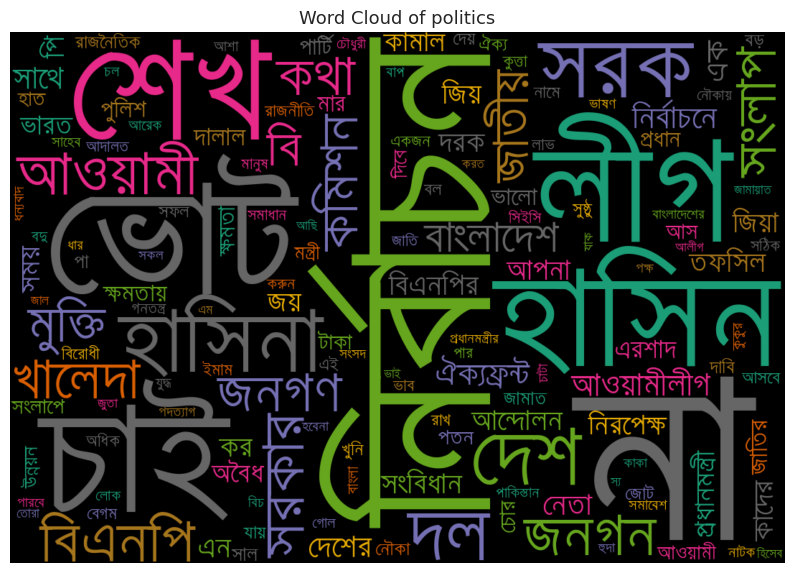

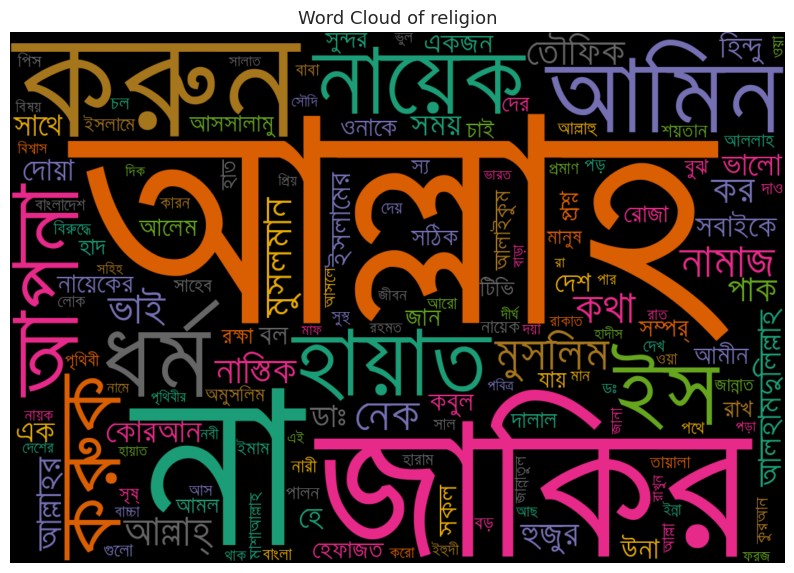

In [ ]:
from collections import Counter
aspect_cat=["other","sports","politics","religion"]
for i in aspect_cat:
    temp_df=df.loc[df['aspect'] == str(i)]
    #display(temp)
    temp_df['temp'] = temp_df['cleanText'].apply(lambda x:str(x).split())
    top = Counter([item for sublist in temp_df['temp'] for item in sublist])
    temp = pd.DataFrame(top.most_common(5000))
    temp.columns = ['Common_words','count']
    generate_wordcloud(temp,str(i))

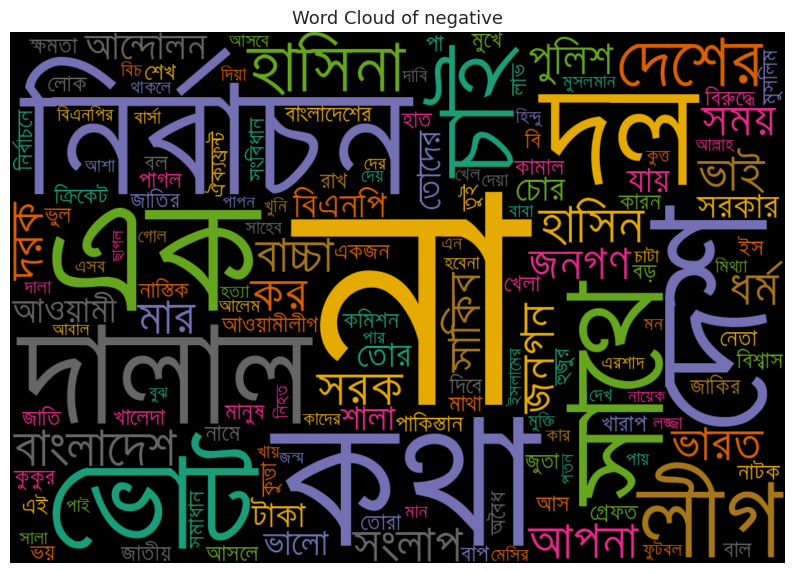

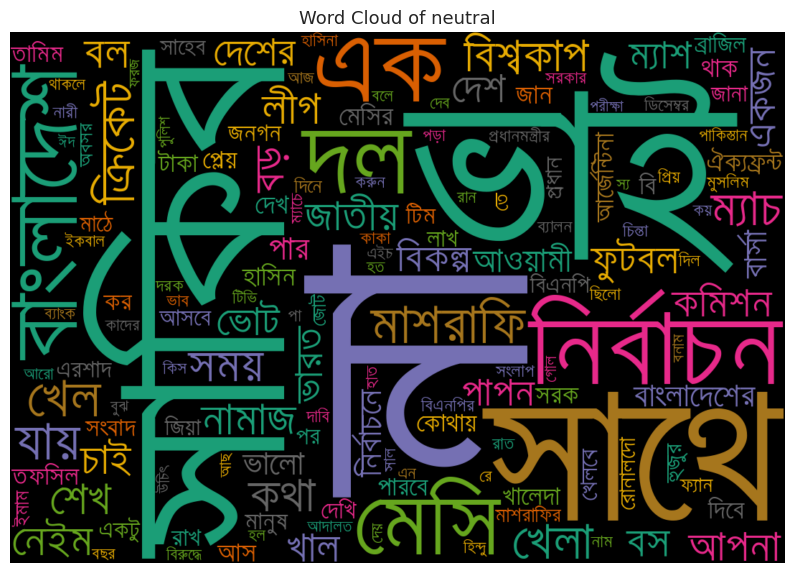

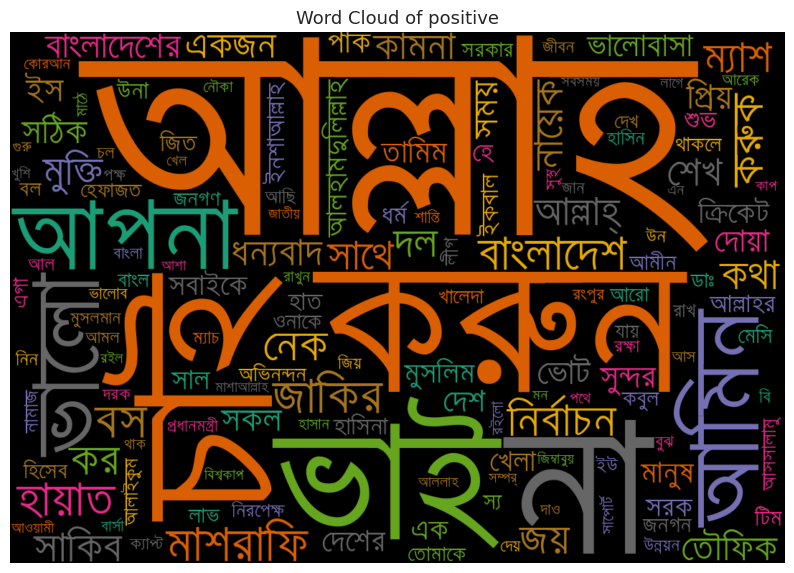

In [ ]:
from collections import Counter
polarity_cat=["negative","neutral","positive"]
for i in polarity_cat:
    temp_df=df.loc[df['polarity'] == str(i)]
    #display(temp)
    temp_df['temp'] = temp_df['cleanText'].apply(lambda x:str(x).split())
    top = Counter([item for sublist in temp_df['temp'] for item in sublist])
    temp = pd.DataFrame(top.most_common(5000))
    temp.columns = ['Common_words','count']
    generate_wordcloud(temp,str(i))

In [ ]:
df['temp_list'] = df['cleanText'].apply(lambda x:str(x).split())
top = Counter([item for sublist in df['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
0,না,906
1,আল্লাহ,305
2,কথা,216
3,নির্বাচন,208
4,চাই,195
5,ভাই,194
6,এক,189
7,দল,183
8,সাথে,171
9,বাংলাদেশ,168


In [ ]:
# Top words in aspect columns (category wise)
from collections import Counter
aspect_cat=["other","sports","politics","religion"]
category_list_aspect=aspect_cat
for i in category_list_aspect:
    temp=df.loc[df['aspect'] == str(i)]
    #display(temp)
    temp['temp_list'] = temp['cleanText'].apply(lambda x:str(x).split())
    top = Counter([item for sublist in temp['temp_list'] for item in sublist])
    temp = pd.DataFrame(top.most_common(20))
    temp.style.background_gradient(cmap='Blues')
    temp = temp.style.set_caption('Top 20 Words In '+ str(i)+" Category")
    display(temp)
    print()
    print()

,0,1
0,না,257
1,কথা,70
2,এক,52
3,দেশ,50
4,বাচ্চা,42
5,দালাল,40
6,দেশের,39
7,পুলিশ,38
8,কর,36
9,আপনা,34


,0,1
0,না,213
1,সাকিব,141
2,মাশরাফি,119
3,ভাই,116
4,ক্রিকেট,97
5,বস,89
6,দল,87
7,খেলা,85
8,বাংলাদেশ,83
9,সাথে,74


,0,1
0,না,291
1,নির্বাচন,203
2,ভোট,123
3,চাই,115
4,লীগ,104
5,শেখ,100
6,হাসিন,99
7,হাসিনা,98
8,সরক,97
9,দেশ,82


,0,1
0,আল্লাহ,292
1,না,145
2,জাকির,106
3,করুন,103
4,আমিন,82
5,ধর্ম,79
6,নায়েক,65
7,হায়াত,64
8,আপনা,63
9,ইস,63


In [ ]:
# Top words in aspect columns (category wise)
polarity_cat=["negative","neutral","positive"]
category_list_pol=polarity_cat
for i in category_list_pol:
    temp=df.loc[df['polarity'] == str(i)]
    #display(temp)
    temp['temp_list'] = temp['cleanText'].apply(lambda x:str(x).split())
    top = Counter([item for sublist in temp['temp_list'] for item in sublist])
    temp = pd.DataFrame(top.most_common(20))
    temp.style.background_gradient(cmap='Blues')
    temp = temp.style.set_caption('Top 20 Words In '+ str(i)+" Category")
    display(temp)
    print()
    print()

,0,1
0,না,710
1,কথা,147
2,দেশ,120
3,এক,117
4,নির্বাচন,108
5,দল,93
6,দালাল,84
7,সাথে,80
8,ভোট,74
9,লীগ,73


,0,1
0,না,97
1,ভাই,49
2,সাকিব,46
3,সাথে,46
4,নির্বাচন,45
5,এক,44
6,দল,44
7,বাংলাদেশ,36
8,মেসি,33
9,মাশরাফি,32


,0,1
0,আল্লাহ,277
1,চাই,106
2,করুন,106
3,না,99
4,ভাই,84
5,আপনা,82
6,আমিন,80
7,ভালো,74
8,মাশরাফি,70
9,জাকির,69


In [ ]:
df=df[["cleanText","aspect","polarity"]]
print(df.shape)

(6063, 3)


In [ ]:
df.head()

,cleanText,aspect,polarity
3,পরিসংখ্যান ম্যাশ হইতো এশিয়া কাপ,sports,neutral
4,রুহুল আমিন হাওল আসনে কয়ভোট পাবে নিজে জানেনা,politics,neutral
6,কিছুদিন মাঠে না ভালোবাসা চিরকাল,sports,positive
7,সংলাপ সফল আন্দোলন চলবে,politics,negative
9,আল্লাহ সর্বজ্ঞ সর্ববিষয় সম্যক জ্ঞাত,religion,positive


In [ ]:
#Initialize the model

PRE_TRAINED_MODEL_NAME = "sagorsarker/bangla-bert-base" #Bangla bert
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

vocab.txt:   0%|          | 0.00/2.24M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/491 [00:00<?, ?B/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Text(0.5, 0, 'Token count')

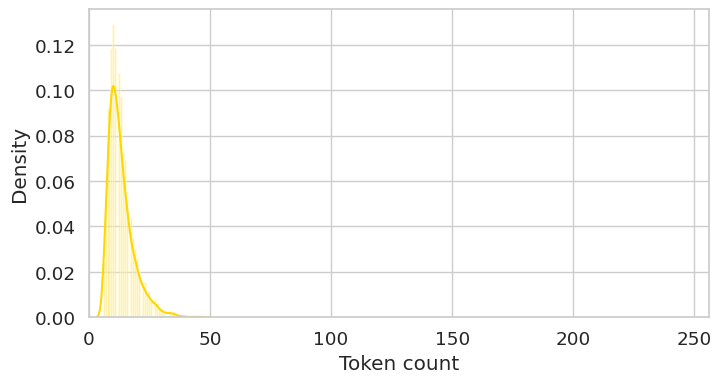

In [ ]:
#Choosing Sequence Length
#BERT works with fixed-length sequences. We'll use a simple strategy to choose the max length. Let's store the token length of each review.
token_lens = []

for txt in df.cleanText:
    tokens = tokenizer.encode(txt,max_length=512) #each row contain fixed length of 512
    token_lens.append(len(tokens))

sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count')

In [ ]:
# Import label encoder
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [ ]:
df['aspect']= le.fit_transform(df['aspect'])
df['polarity']= le.fit_transform(df['polarity'])

In [ ]:
df.aspect.value_counts()

,count
aspect,
1,1922
0,1521
2,1313
3,1307


In [ ]:
df.aspect.value_counts()

,count
aspect,
1,1922
0,1521
2,1313
3,1307


In [ ]:
df.head()

,cleanText,aspect,polarity
3,পরিসংখ্যান ম্যাশ হইতো এশিয়া কাপ,3,1
4,রুহুল আমিন হাওল আসনে কয়ভোট পাবে নিজে জানেনা,1,1
6,কিছুদিন মাঠে না ভালোবাসা চিরকাল,3,2
7,সংলাপ সফল আন্দোলন চলবে,1,0
9,আল্লাহ সর্বজ্ঞ সর্ববিষয় সম্যক জ্ঞাত,2,2


In [ ]:
#split the data....
df_train, df_test = train_test_split(df,test_size=0.2, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)
print("train shape:",df_train.shape)
print("test shape:",df_test.shape)
print("val shape:",df_val.shape)

train shape: (4850, 3)
test shape: (607, 3)
val shape: (606, 3)


In [ ]:
#Dataset building.........

class_name=["others","politices","religion","sports"]
MAX_LEN = 40

class NewsHeadlineDataset(Dataset):
    def __init__(self, text, aspect_targets, polarity_targets, tokenizer, max_len):
        self.text = text
        self.aspect_targets = aspect_targets
        self.polarity_targets = polarity_targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        aspect_target = self.aspect_targets[index]
        polarity_target = self.polarity_targets[index]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'review_text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'aspect_targets': torch.tensor(aspect_target, dtype=torch.long),
            'polarity_targets': torch.tensor(polarity_target, dtype=torch.long),
        }


In [ ]:
#Create Data Loader...........

def create_data_loader(df, tokenizer, max_len, batch_size):
    #create a instance of the GPReview class.
    ds = NewsHeadlineDataset(
        text=df.cleanText.to_numpy(),
        aspect_targets=df.aspect.to_numpy(),
        polarity_targets=df.polarity.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len)

    return DataLoader(
        ds,
        batch_size=batch_size)

BATCH_SIZE = 64

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)


In [ ]:
class HeadlineClassifier(nn.Module):
    def __init__(self, num_aspect_classes, num_polarity_classes):
        super(HeadlineClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=False)
        self.drop = nn.Dropout(0.5)

        # Separate output heads for each task
        self.aspect_out = nn.Linear(self.bert.config.hidden_size, num_aspect_classes)
        self.polarity_out = nn.Linear(self.bert.config.hidden_size, num_polarity_classes)

    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=False
        )
        output = self.drop(pooled_output)

        # Outputs for the two tasks
        aspect_output = self.aspect_out(output)
        polarity_output = self.polarity_out(output)

        return aspect_output, polarity_output


# Initialize the model with appropriate number of classes
num_aspect_classes = len(class_name)  # For 'aspect_targets' classification
num_polarity_classes = 3  # Assuming 3 classes for polarity (positive, negative, neutral)

model = HeadlineClassifier(num_aspect_classes, num_polarity_classes)


model.safetensors:   0%|          | 0.00/660M [00:00<?, ?B/s]

In [ ]:
# ----------------------------------- Training ----------------------------------
EPOCHS = 10

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

aspect_loss_fn = nn.CrossEntropyLoss()
polarity_loss_fn = nn.CrossEntropyLoss()

# Training function
def train_epoch(
    model,
    data_loader,
    aspect_loss_fn,
    polarity_loss_fn,
    optimizer,
    scheduler,
    n_examples,
    device
):
    model = model.train()
    model.to(device)

    aspect_losses = []
    polarity_losses = []
    correct_aspect_predictions = 0
    correct_polarity_predictions = 0

    for batch in data_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        aspect_targets = batch["aspect_targets"].to(device)
        polarity_targets = batch["polarity_targets"].to(device)

        aspect_outputs, polarity_outputs = model(input_ids=input_ids, attention_mask=attention_mask)

        _, aspect_preds = torch.max(aspect_outputs, dim=1)
        _, polarity_preds = torch.max(polarity_outputs, dim=1)

        aspect_loss = aspect_loss_fn(aspect_outputs, aspect_targets)
        polarity_loss = polarity_loss_fn(polarity_outputs, polarity_targets)

        loss = aspect_loss + polarity_loss

        correct_aspect_predictions += torch.sum(aspect_preds == aspect_targets)
        correct_polarity_predictions += torch.sum(polarity_preds == polarity_targets)

        aspect_losses.append(aspect_loss.item())
        polarity_losses.append(polarity_loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    aspect_accuracy = correct_aspect_predictions.double() / n_examples
    polarity_accuracy = correct_polarity_predictions.double() / n_examples

    avg_aspect_loss = np.mean(aspect_losses)
    avg_polarity_loss = np.mean(polarity_losses)

    return aspect_accuracy, polarity_accuracy, avg_aspect_loss, avg_polarity_loss






In [ ]:
# Evaluation function
def eval_model(
    model,
    data_loader,
    aspect_loss_fn,
    polarity_loss_fn,
    n_examples,
    device
):
    model = model.eval()
    model.to(device)

    aspect_losses = []
    polarity_losses = []
    correct_aspect_predictions = 0
    correct_polarity_predictions = 0

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            aspect_targets = batch["aspect_targets"].to(device)
            polarity_targets = batch["polarity_targets"].to(device)

            aspect_outputs, polarity_outputs = model(input_ids=input_ids, attention_mask=attention_mask)

            _, aspect_preds = torch.max(aspect_outputs, dim=1)
            _, polarity_preds = torch.max(polarity_outputs, dim=1)

            aspect_loss = aspect_loss_fn(aspect_outputs, aspect_targets)
            polarity_loss = polarity_loss_fn(polarity_outputs, polarity_targets)

            correct_aspect_predictions += torch.sum(aspect_preds == aspect_targets)
            correct_polarity_predictions += torch.sum(polarity_preds == polarity_targets)

            aspect_losses.append(aspect_loss.item())
            polarity_losses.append(polarity_loss.item())

    aspect_accuracy = correct_aspect_predictions.double() / n_examples
    polarity_accuracy = correct_polarity_predictions.double() / n_examples

    avg_aspect_loss = np.mean(aspect_losses)
    avg_polarity_loss = np.mean(polarity_losses)

    return aspect_accuracy, polarity_accuracy, avg_aspect_loss, avg_polarity_loss



In [ ]:
# --------------------------- Starting the Training Process -------------------------------
from collections import defaultdict

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print("-" * 100)

    train_aspect_acc, train_polarity_acc, train_aspect_loss, train_polarity_loss = train_epoch(
        model=model,
        data_loader=train_data_loader,
        aspect_loss_fn=aspect_loss_fn,
        polarity_loss_fn=polarity_loss_fn,
        optimizer=optimizer,
        scheduler=scheduler,
        n_examples=len(df_train),
        device=device
    )

    print(f"Train Aspect Loss: {train_aspect_loss}  ##  Train Aspect Accuracy: {train_aspect_acc}")
    print(f"Train Polarity Loss: {train_polarity_loss}  ##  Train Polarity Accuracy: {train_polarity_acc}")

    val_aspect_acc, val_polarity_acc, val_aspect_loss, val_polarity_loss = eval_model(
        model=model,
        data_loader=val_data_loader,
        aspect_loss_fn=aspect_loss_fn,
        polarity_loss_fn=polarity_loss_fn,
        n_examples=len(df_val),
        device=device
    )

    print(f"Val Aspect Loss: {val_aspect_loss}  ##  Val Aspect Accuracy: {val_aspect_acc}")
    print(f"Val Polarity Loss: {val_polarity_loss}  ##  Val Polarity Accuracy: {val_polarity_acc}")
    print()

    history["train_aspect_acc"].append(train_aspect_acc)
    history["train_polarity_acc"].append(train_polarity_acc)
    history["train_aspect_loss"].append(train_aspect_loss)
    history["train_polarity_loss"].append(train_polarity_loss)
    history["val_aspect_acc"].append(val_aspect_acc)
    history["val_polarity_acc"].append(val_polarity_acc)
    history["val_aspect_loss"].append(val_aspect_loss)
    history["val_polarity_loss"].append(val_polarity_loss)

    if val_aspect_acc + val_polarity_acc > best_accuracy:
        torch.save(model.state_dict(), "/content/drive/MyDrive/BanglaNewsHeadline_Classifications_with_BanglaBERT/best_model_state1.bin")
        best_accuracy = val_aspect_acc + val_polarity_acc

Epoch 1/10
----------------------------------------------------------------------------------------------------
Train Aspect Loss: 0.057878235207968635  ##  Train Aspect Accuracy: 0.9874226804123711
Train Polarity Loss: 0.1359578863178429  ##  Train Polarity Accuracy: 0.9536082474226805
Val Aspect Loss: 0.6017580687999725  ##  Val Aspect Accuracy: 0.8547854785478548
Val Polarity Loss: 1.1150807738304138  ##  Val Polarity Accuracy: 0.6831683168316832

Epoch 2/10
----------------------------------------------------------------------------------------------------
Train Aspect Loss: 0.03825720596911484  ##  Train Aspect Accuracy: 0.9931958762886598
Train Polarity Loss: 0.09020987057470177  ##  Train Polarity Accuracy: 0.9740206185567011
Val Aspect Loss: 0.595083412528038  ##  Val Aspect Accuracy: 0.8432343234323433
Val Polarity Loss: 1.2422619104385375  ##  Val Polarity Accuracy: 0.6864686468646864

Epoch 3/10
--------------------------------------------------------------------------------

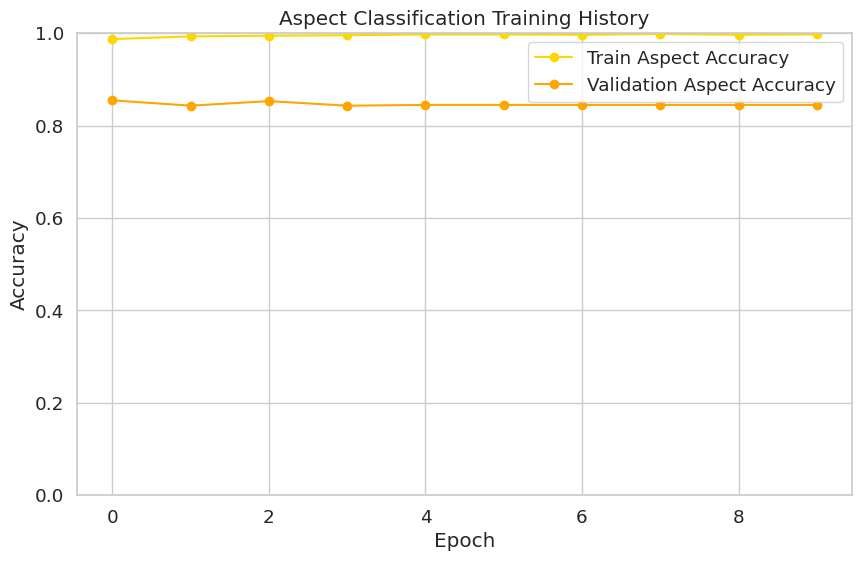

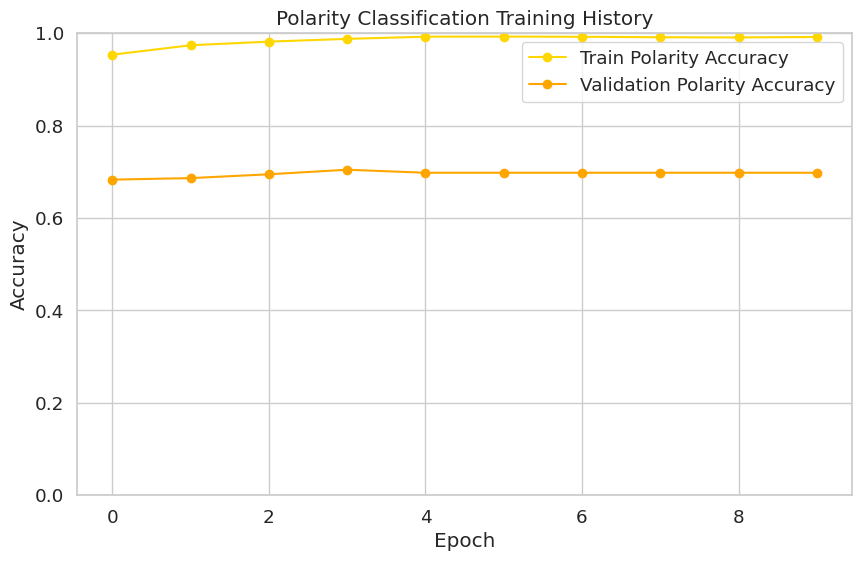

In [ ]:
# Ensure accuracy values are converted to CPU and numpy arrays for plotting
train_aspect_acc = [acc.cpu().numpy() for acc in history['train_aspect_acc']]
val_aspect_acc = [acc.cpu().numpy() for acc in history['val_aspect_acc']]
train_polarity_acc = [acc.cpu().numpy() for acc in history['train_polarity_acc']]
val_polarity_acc = [acc.cpu().numpy() for acc in history['val_polarity_acc']]

# Plot aspect classification accuracy
plt.figure(figsize=(10, 6))
plt.plot(train_aspect_acc, label='Train Aspect Accuracy', marker='o')
plt.plot(val_aspect_acc, label='Validation Aspect Accuracy', marker='o')
plt.title('Aspect Classification Training History')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1])
plt.grid(True)
plt.show()

# Plot polarity classification accuracy
plt.figure(figsize=(10, 6))
plt.plot(train_polarity_acc, label='Train Polarity Accuracy', marker='o')
plt.plot(val_polarity_acc, label='Validation Polarity Accuracy', marker='o')
plt.title('Polarity Classification Training History')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1])
plt.grid(True)
plt.show()


In [ ]:
aspect_class_names=["others","politices","religion","sports"]
polarity_class_names=["negative","neutral","positive"]

In [ ]:
# Load the saved model
model = HeadlineClassifier(num_aspect_classes=len(aspect_class_names), num_polarity_classes=len(polarity_class_names))
model.load_state_dict(torch.load('/content/drive/MyDrive/BanglaNewsHeadline_Classifications_with_BanglaBERT/best_model_state1.bin'))
model = model.to(device)


In [ ]:
# Evaluation on test data
test_aspect_acc, test_polarity_acc, _, _ = eval_model(
    model,
    test_data_loader,
    aspect_loss_fn,
    polarity_loss_fn,
    len(df_test),
    device
)

print("Test Aspect Accuracy:", test_aspect_acc.item())
print("Test Polarity Accuracy:", test_polarity_acc.item())


Test Aspect Accuracy: 0.8385502471169687
Test Polarity Accuracy: 0.7232289950576606


In [ ]:
# Function to get predictions
def get_predictions(model, data_loader):
    model = model.eval()

    review_texts = []
    aspect_predictions = []
    polarity_predictions = []
    aspect_probs = []
    polarity_probs = []
    aspect_targets = []
    polarity_targets = []

    with torch.no_grad():
        for d in data_loader:
            texts = d["review_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            aspect_labels = d["aspect_targets"].to(device)
            polarity_labels = d["polarity_targets"].to(device)

            aspect_outputs, polarity_outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            _, aspect_preds = torch.max(aspect_outputs, dim=1)
            _, polarity_preds = torch.max(polarity_outputs, dim=1)

            aspect_probs_batch = F.softmax(aspect_outputs, dim=1)
            polarity_probs_batch = F.softmax(polarity_outputs, dim=1)

            review_texts.extend(texts)
            aspect_predictions.extend(aspect_preds)
            polarity_predictions.extend(polarity_preds)
            aspect_probs.extend(aspect_probs_batch)
            polarity_probs.extend(polarity_probs_batch)
            aspect_targets.extend(aspect_labels)
            polarity_targets.extend(polarity_labels)

    aspect_predictions = torch.stack(aspect_predictions).cpu()
    polarity_predictions = torch.stack(polarity_predictions).cpu()
    aspect_probs = torch.stack(aspect_probs).cpu()
    polarity_probs = torch.stack(polarity_probs).cpu()
    aspect_targets = torch.stack(aspect_targets).cpu()
    polarity_targets = torch.stack(polarity_targets).cpu()

    return review_texts, aspect_predictions, polarity_predictions, aspect_probs, polarity_probs, aspect_targets, polarity_targets


In [ ]:
# Get predictions
y_review_texts, y_aspect_pred, y_polarity_pred, y_aspect_probs, y_polarity_probs, y_aspect_true, y_polarity_true = get_predictions(
    model,
    test_data_loader
)

# Print classification reports for aspect and polarity
print("Aspect Classification Report:")
print(classification_report(y_aspect_true, y_aspect_pred, target_names=aspect_class_names))

print("\nPolarity Classification Report:")
print(classification_report(y_polarity_true, y_polarity_pred, target_names=polarity_class_names))


Aspect Classification Report:
              precision    recall  f1-score   support

      others       0.75      0.77      0.76       164
   politices       0.86      0.82      0.84       196
    religion       0.84      0.91      0.88       113
      sports       0.93      0.90      0.91       134

    accuracy                           0.84       607
   macro avg       0.84      0.85      0.85       607
weighted avg       0.84      0.84      0.84       607


Polarity Classification Report:
              precision    recall  f1-score   support

    negative       0.80      0.82      0.81       342
     neutral       0.46      0.48      0.47       103
    positive       0.73      0.69      0.70       162

    accuracy                           0.72       607
   macro avg       0.66      0.66      0.66       607
weighted avg       0.72      0.72      0.72       607



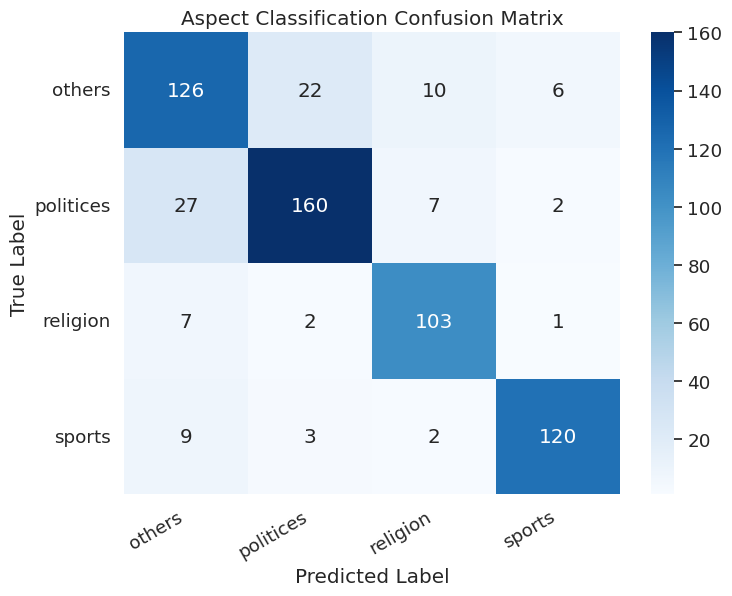

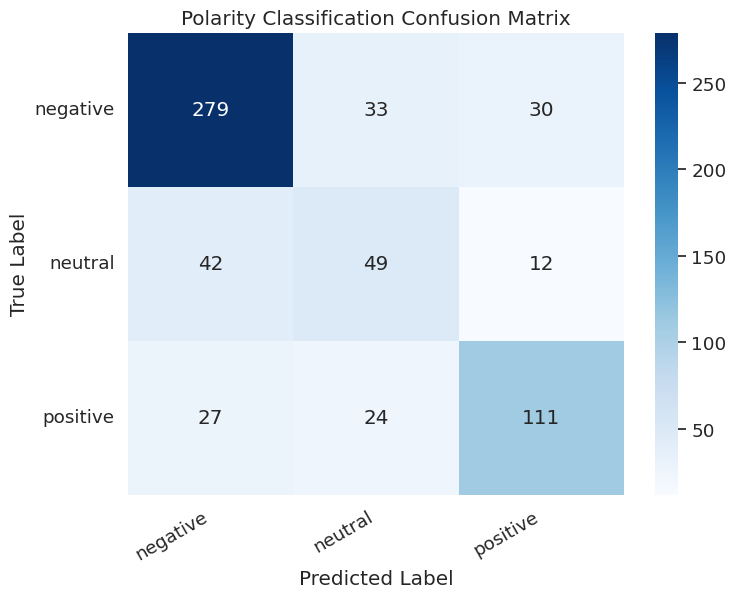

In [ ]:
# Function to display confusion matrix
def show_confusion_matrix(confusion_matrix, class_names, title):
    plt.figure(figsize=(8, 6))
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title(title)
    plt.show()

# Aspect confusion matrix
aspect_cm = confusion_matrix(y_aspect_true, y_aspect_pred)
show_confusion_matrix(aspect_cm, aspect_class_names, title="Aspect Classification Confusion Matrix")

# Polarity confusion matrix
polarity_cm = confusion_matrix(y_polarity_true, y_polarity_pred)
show_confusion_matrix(polarity_cm, polarity_class_names, title="Polarity Classification Confusion Matrix")


In [ ]:
def predict_text(text):
    # Preprocess the input text
    text = preprocessing(str(text))
    # text = stopwordRemoval(text)
    # text = stem_text(text)

    # Tokenize and encode the input
    encoded = tokenizer.encode_plus(
        text,
        max_length=MAX_LEN,
        add_special_tokens=True,
        return_token_type_ids=False,
        pad_to_max_length=True,
        return_attention_mask=True,
        return_tensors='pt'
    )

    input_ids = encoded['input_ids'].to(device)
    attention_mask = encoded['attention_mask'].to(device)

    # Get predictions from the model
    model.eval()
    with torch.no_grad():
        aspect_outputs, polarity_outputs = model(input_ids, attention_mask)
        _, aspect_prediction = torch.max(aspect_outputs, dim=1)
        _, polarity_prediction = torch.max(polarity_outputs, dim=1)

    # Print predictions
    print("\n" + "-" * 50)
    print(f"Processed Text: {text}")
    print(f"Predicted Aspect Class   : {aspect_class_names[aspect_prediction.item()]}")
    print(f"Predicted Polarity Class : {polarity_class_names[polarity_prediction.item()]}")
    print("-" * 50 + "\n")


In [ ]:
# set your headline for predicting the outputs.
text = "আল্লাহ তায়ালা আপনাকে নেক হায়াত দান করুক"

# call for the generate function.
predict_text(text)


--------------------------------------------------
Processed Text: আল্লাহ তায়ালা আপনাকে নেক হায়াত দান করুক
Predicted Aspect Class   : religion
Predicted Polarity Class : positive
--------------------------------------------------

